## Sequential CNN for classification -  basic keras augmentation in joint training

Joint trainig - weight tying in autoencoder, 1 dense layer in classifier , Adam optimizer 0.001

In [1]:
%matplotlib inline
import os
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, Activation, BatchNormalization,\
                         Flatten, Dense, Conv2DTranspose, Reshape,MaxPooling2D, \
                         UpSampling2D, Lambda, Dropout, Concatenate
from tensorflow.keras.optimizers import SGD,Adam,RMSprop
from tensorflow.keras.regularizers import l1,l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.utils import class_weight
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import pickle
import random
import collections
import matplotlib.pyplot as plt
import seaborn as sns

random.seed(11)
tf.set_random_seed(11)
data_path = "cifar-10-batches-py" 

# *Read Data*

In [2]:
def unpickle(file):
    with open(file, 'rb') as fo:
        datadict = pickle.load(fo, encoding='bytes')
    return datadict

In [3]:
label_path = os.path.join(data_path,'batches.meta')
label_dict = unpickle(label_path) 
class_list_b = label_dict[b'label_names']
cut_factor = 0.5
bird = 2
deer = 4
truck = 9
downsample_list = [2,4,9]
class_list=[]
for each in class_list_b:
    class_list.append(each.decode('utf8'))

In [40]:
def load_train_data(data_path):
    for i in range(1,6):
        batch_path = os.path.join(data_path, 'data_batch_' + str(i))
        data_dict = unpickle(batch_path)
        #d =collections.Counter(data_dict[b'labels'])
        #dd = collections.OrderedDict(sorted(d.items(), key=lambda t: t[0]))
        #print(d)
        #print(dd)
        if (i == 1):
            train_data = data_dict[b'data']
            train_labels = data_dict[b'labels']
            
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
            train_labels += data_dict[b'labels']
    
    
    train_data = train_data.reshape((len(train_data),3,32, 32))
    train_data = train_data.transpose(0, 2, 3, 1)
    train_labels = np.asarray(train_labels)
    
    data_dict = unpickle(data_path+"/test_batch")
    test_data = np.asarray(data_dict[b'data'])
    test_labels = np.asarray(data_dict[b'labels'])
    
    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = test_data.transpose(0, 2, 3, 1)
    return train_data,train_labels,test_data,test_labels

def downsample_data(downsample_list,Xtrain,Ytrain,cut_factor):
    for i,class_id in enumerate(downsample_list):
        label_idx = [idx for idx, y in enumerate(Ytrain) if y == class_id]
        if (i == 0):
            downsample_ids = random.sample(label_idx,(int)(cut_factor*len(label_idx)))
        else:
            downsample_ids += random.sample(label_idx,(int)(cut_factor*len(label_idx)))
    downsample_ids = sorted(downsample_ids)
    new_Xtrain = np.delete(Xtrain,downsample_ids,axis=0)
    new_Ytrain = np.delete(Ytrain,downsample_ids,axis=0)
    return new_Xtrain,new_Ytrain    

full_Xtrain,full_Ytrain,Xtest,Ytest = load_train_data(data_path)
Xtrain,Ytrain = downsample_data(downsample_list,full_Xtrain,full_Ytrain,cut_factor)
print(Xtrain.shape)
print(Ytrain.shape)
print(Xtest.shape)
print(Ytest.shape)

class_weights = list(class_weight.compute_class_weight(
               'balanced',
                np.unique(Ytrain), 
                Ytrain.reshape(Ytrain.shape[0])))
print(class_weights)


#d =collections.Counter(new_Ytrain)
#print(collections.OrderedDict(sorted(d.items(), key=lambda t: t[0])))
num_training_imgs = Xtrain.shape[0]
num_test_imgs = Xtest.shape[0]
num_classes = len(np.unique(Ytrain))

print(num_classes,num_training_imgs,num_test_imgs)
YtrainHot = keras.utils.to_categorical(Ytrain, num_classes)
YtestHot = keras.utils.to_categorical(Ytest, num_classes)


(42500, 32, 32, 3)
(42500,)
(10000, 32, 32, 3)
(10000,)
[0.85, 0.85, 1.7, 0.85, 1.7, 0.85, 0.85, 0.85, 0.85, 1.7]
10 42500 10000


In [ ]:
Xtrain = Xtrain.astype('float32') / 255.
Xtest = Xtest.astype('float32') / 255.

# # mean-subtraction
# Xtrain_mean = np.mean(Xtrain, axis=(0))
# Xtrain -= Xtrain_mean
# Xtest -= Xtrain_mean

# standardization
# Xtrain_mean = np.mean(Xtrain,axis=(0,1,2))
# std = np.std(Xtrain,axis=(0,1,2))
# Xtrain = Xtrain/(std+1e-7)
# Xtest = Xtest/(std+1e-7)
# print(Xtrain_mean)
# print(std)


num_classes = 10

In [ ]:
def check_images(images):
    fig = plt.figure(figsize=(15, 4))
    columns = 8
    rows = 3
    for i in range(1, columns*rows+1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1])
    
    fig.subplots_adjust(hspace=0.1)
    fig.subplots_adjust(wspace=0)
    plt.axis('off')
    #plt.tight_layout()
    plt.show()
    
check_images(Xtrain)

# Evaluation functions

In [6]:
def visualize_reconstruction(ip, dec, num=10):
    n = num
    plt.figure(figsize=(20, 4))
    mse = np.mean(((ip.astype("float") - dec.astype("float"))**2),axis=(0,1,2,3))
    print(mse)   
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(ip[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(dec[i].reshape(32, 32, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
def evaluate_classification(Ytest,Ypred):
    cm=confusion_matrix(Ytest, Ypred)
    print("Classification Report:\n")
    cr=classification_report(Ytest,Ypred,target_names=class_list)
    print(cr)
    plt.figure(figsize=(12,12))
    sns.heatmap(cm, annot=True, cmap="Blues", xticklabels = class_list, yticklabels = class_list, fmt="d")

## Joint training

In [46]:
def aec_model():
    
    input_img = Input(shape=(32, 32, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same', name='c1')(input_img)
    conv1 = BatchNormalization()(conv1)
    
    conv2 = Conv2D(32, kernel_size=3, activation='relu', padding='same',name = 'c2')(conv1)
    conv2 = BatchNormalization(name = 'c2bn')(conv2)
    conv2p = MaxPooling2D(pool_size=(2, 2))(conv2) #16
    
    conv3 = Conv2D(64,kernel_size=3, activation='relu', padding='same', name = 'c3')(conv2p)
    conv3 = BatchNormalization()(conv3)
    
    conv4 = Conv2D(64,kernel_size=3, activation='relu', padding='same', name = 'c4')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4p = MaxPooling2D(pool_size=(2, 2),name='encoder')(conv4)   #8

    enc_opt = conv4p
    flatten_opt = Flatten(name = 'flatten_enc')(conv4p)
    enc_opt = Reshape((8, 8, 64))(flatten_opt)
    
    #conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4p)
    #conv5 = BatchNormalization()(conv5)
    #enc_opt = conv5
        
    convt6 = Conv2DTranspose(64, kernel_size=2, strides=2)(enc_opt)
    convt6 = BatchNormalization()(convt6)
    
    #convtcat6 = Concatenate()([convt6, conv4])
    
    conv6 = Conv2D(64,kernel_size=3, activation='relu', padding='same', name = 'c4d')(convt6)
    conv6 = BatchNormalization()(conv6)
    
    #print(convtcat6)
    convt7 = Conv2DTranspose(32, kernel_size=2, strides=2)(conv6)
    convt7 = BatchNormalization()(convt7)
    #convtcat7 = Concatenate()([convt7, conv2])
    #print(convtcat7)
    conv8 = Conv2D(32,kernel_size=2,activation='relu', padding='same')(convt7)
    
    # reconstruction
    dec_opt = Conv2D(3,kernel_size =1,activation = 'sigmoid',name='decoder')(conv8)
    
    conv= Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', name = 'cb_1')(enc_opt)
    conv = BatchNormalization(name = 'cbn_1')(conv)
    conv = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',name='cb_2')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D((2, 2))(conv)
    conv = Dropout(0.2)(conv)
    conv = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',name = 'cb_4')(conv)
    conv = BatchNormalization()(conv)
    conv = MaxPooling2D((2, 2))(conv)
    conv = Dropout(0.2)(conv)
    classification = Flatten()(conv)
    classification = Dense(128, activation='relu', kernel_initializer='he_uniform',activity_regularizer=l2(0.00005))(classification)
    classification = BatchNormalization()(classification)
    classification = Dropout(0.5)(classification)
    classification = Dense(10, activation='softmax',name='classifier')(classification)
                        
    
    return Model(inputs = input_img, outputs = [dec_opt, classification])
    

In [47]:
aec_model = aec_model()
opt = Adam()
#opt= SGD(lr= 0.001, momentum= 0.9)

aec_model.compile(loss = {'decoder': 'mean_squared_error','classifier': 'categorical_crossentropy'}, 
                  loss_weights = {'decoder': 1.0, 'classifier': 1.0}, 
                  optimizer = opt,
                  metrics = {'classifier': ['accuracy'], 'decoder': []})


train_datagen = ImageDataGenerator(shear_range=0.1,rescale=1./255,rotation_range=20, brightness_range=[0.2,0.7],
                                   width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,
                                   vertical_flip=True, fill_mode="nearest")#,preprocessing_function=cutOut(v_l=0, v_h=1))

test_datagen = ImageDataGenerator() 


def image_generator(datagen,Xtrain,Ytrain,batchsize):
    gen = datagen.flow(Xtrain, Ytrain, batch_size=batchsize)
    while(True):
        Xtrain_data, Ytrain_data = gen.next()
        yield Xtrain_data, {'decoder': Xtrain_data,'classifier': Ytrain_data}
     
mcp_callback_j = ModelCheckpoint('aug_cmodel-{epoch:03d}-{classifier_acc:03f}-{val_classifier_acc:03f}.h5', verbose=1, monitor='val_classifier_acc',save_best_only=True, mode='auto') 
estop_callback_j = EarlyStopping(monitor='val_classifier_acc', patience=20, min_delta=0.0005, restore_best_weights=True,verbose=1)
lrdecay_callback_j = ReduceLROnPlateau(monitor='val_classifier_acc', factor=0.1, patience=20, min_delta=0.001,min_lr=0.00001,verbose=1)
callbacks = [lrdecay_callback_j, estop_callback_j, mcp_callback_j]


# history = aec_model.fit(Xtrain, [Xtrain,YtrainHot], batch_size=batch_size, epochs=200, 
#                           validation_data = (Xtest, [Xtest,YtestHot]),
#                           shuffle=True)
# #                           class_weight=class_weights
batch_size = 64
steps = Xtrain.shape[0]//batch_size
# for i in range(100):
#     gen = train_datagen.flow(Xtrain, YtrainHot, batch_size=batch_size)
#     Xtrain_data, Ytrain_data = gen.next()
#     print(Xtrain_data.shape)
#     print(Ytrain_data.shape)

# history = aec_model.fit(Xtrain,{'decoder': Xtrain,'classifier': YtrainHot},
#         epochs=150,callbacks = callbacks,
#         shuffle=True, #class_weight=class_weights,
#         validation_data=(Xtest,{'decoder': Xtest,'classifier': YtestHot}))



history = aec_model.fit_generator(
        image_generator(train_datagen,Xtrain,YtrainHot,batch_size),
        steps_per_epoch=steps,
        epochs=300, class_weight={'decoder': class_weights,'classifier': class_weights}, 
        shuffle=True, callbacks=callbacks,
        validation_data=(Xtest,{'decoder': Xtest,'classifier': YtestHot}))


Epoch 1/450
663/664 [============================>.] - ETA: 0s - loss: 1.9755 - decoder_loss: 0.0054 - classifier_loss: 1.9251 - classifier_acc: 0.3320
Epoch 00001: val_classifier_acc improved from -inf to 0.40140, saving model to aug_cmodel-001-0.332149-0.401400.h5
664/664 [==============================] - 92s 139ms/step - loss: 1.9749 - decoder_loss: 0.0054 - classifier_loss: 1.9245 - classifier_acc: 0.3321 - val_loss: 1.7096 - val_decoder_loss: 0.0224 - val_classifier_loss: 1.6460 - val_classifier_acc: 0.4014
Epoch 2/450
663/664 [============================>.] - ETA: 0s - loss: 1.5279 - decoder_loss: 0.0031 - classifier_loss: 1.4896 - classifier_acc: 0.4637
Epoch 00002: val_classifier_acc improved from 0.40140 to 0.40630, saving model to aug_cmodel-002-0.463922-0.406300.h5
664/664 [==============================] - 56s 84ms/step - loss: 1.5275 - decoder_loss: 0.0031 - classifier_loss: 1.4892 - classifier_acc: 0.4639 - val_loss: 1.8109 - val_decoder_loss: 0.0160 - val_classifier_lo

Epoch 17/450
663/664 [============================>.] - ETA: 0s - loss: 0.8321 - decoder_loss: 0.0027 - classifier_loss: 0.8011 - classifier_acc: 0.7262- ETA: 3s - loss: 0.8326 - decoder_loss: 0.0027 - classifie
Epoch 00017: val_classifier_acc did not improve from 0.71950
664/664 [==============================] - 51s 77ms/step - loss: 0.8317 - decoder_loss: 0.0027 - classifier_loss: 0.8007 - classifier_acc: 0.7263 - val_loss: 0.9409 - val_decoder_loss: 0.0410 - val_classifier_loss: 0.8616 - val_classifier_acc: 0.7044
Epoch 18/450
662/664 [============================>.] - ETA: 0s - loss: 0.7964 - decoder_loss: 0.0028 - classifier_loss: 0.7670 - classifier_acc: 0.7375
Epoch 00018: val_classifier_acc did not improve from 0.71950
664/664 [==============================] - 52s 78ms/step - loss: 0.7966 - decoder_loss: 0.0028 - classifier_loss: 0.7673 - classifier_acc: 0.7375 - val_loss: 0.9213 - val_decoder_loss: 0.0265 - val_classifier_loss: 0.8589 - val_classifier_acc: 0.7107
Epoch 19/45

Epoch 34/450
663/664 [============================>.] - ETA: 0s - loss: 0.6305 - decoder_loss: 0.0024 - classifier_loss: 0.6168 - classifier_acc: 0.7890
Epoch 00034: val_classifier_acc did not improve from 0.79270
664/664 [==============================] - 52s 78ms/step - loss: 0.6303 - decoder_loss: 0.0024 - classifier_loss: 0.6166 - classifier_acc: 0.7890 - val_loss: 0.7449 - val_decoder_loss: 0.0205 - val_classifier_loss: 0.7091 - val_classifier_acc: 0.7663
Epoch 35/450
663/664 [============================>.] - ETA: 0s - loss: 0.6068 - decoder_loss: 0.0024 - classifier_loss: 0.5937 - classifier_acc: 0.7973
Epoch 00035: val_classifier_acc did not improve from 0.79270
664/664 [==============================] - 53s 79ms/step - loss: 0.6070 - decoder_loss: 0.0024 - classifier_loss: 0.5939 - classifier_acc: 0.7973 - val_loss: 0.6826 - val_decoder_loss: 0.0227 - val_classifier_loss: 0.6477 - val_classifier_acc: 0.7782
Epoch 36/450
663/664 [============================>.] - ETA: 0s - loss

Epoch 68/450
663/664 [============================>.] - ETA: 0s - loss: 0.4675 - decoder_loss: 0.0021 - classifier_loss: 0.4574 - classifier_acc: 0.8427
Epoch 00068: val_classifier_acc did not improve from 0.83190
664/664 [==============================] - 40s 60ms/step - loss: 0.4676 - decoder_loss: 0.0021 - classifier_loss: 0.4575 - classifier_acc: 0.8427 - val_loss: 0.6022 - val_decoder_loss: 0.0176 - val_classifier_loss: 0.5741 - val_classifier_acc: 0.8107
Epoch 69/450
663/664 [============================>.] - ETA: 0s - loss: 0.4666 - decoder_loss: 0.0021 - classifier_loss: 0.4560 - classifier_acc: 0.8445
Epoch 00069: val_classifier_acc did not improve from 0.83190
664/664 [==============================] - 38s 57ms/step - loss: 0.4664 - decoder_loss: 0.0021 - classifier_loss: 0.4558 - classifier_acc: 0.8445 - val_loss: 0.6296 - val_decoder_loss: 0.0183 - val_classifier_loss: 0.6004 - val_classifier_acc: 0.8037
Epoch 70/450
663/664 [============================>.] - ETA: 0s - loss

Epoch 85/450
663/664 [============================>.] - ETA: 0s - loss: 0.4085 - decoder_loss: 0.0019 - classifier_loss: 0.3980 - classifier_acc: 0.8641
Epoch 00085: val_classifier_acc improved from 0.83250 to 0.84520, saving model to aug_cmodel-085-0.864148-0.845200.h5
664/664 [==============================] - 58s 87ms/step - loss: 0.4085 - decoder_loss: 0.0019 - classifier_loss: 0.3980 - classifier_acc: 0.8641 - val_loss: 0.4931 - val_decoder_loss: 0.0151 - val_classifier_loss: 0.4673 - val_classifier_acc: 0.8452
Epoch 86/450
663/664 [============================>.] - ETA: 0s - loss: 0.3888 - decoder_loss: 0.0019 - classifier_loss: 0.3787 - classifier_acc: 0.8706
Epoch 00086: val_classifier_acc improved from 0.84520 to 0.84640, saving model to aug_cmodel-086-0.870582-0.846400.h5
664/664 [==============================] - 57s 86ms/step - loss: 0.3887 - decoder_loss: 0.0019 - classifier_loss: 0.3786 - classifier_acc: 0.8706 - val_loss: 0.4991 - val_decoder_loss: 0.0149 - val_classifie

Epoch 102/450
663/664 [============================>.] - ETA: 0s - loss: 0.3606 - decoder_loss: 0.0018 - classifier_loss: 0.3537 - classifier_acc: 0.8792
Epoch 00102: val_classifier_acc did not improve from 0.85000
664/664 [==============================] - 55s 83ms/step - loss: 0.3605 - decoder_loss: 0.0018 - classifier_loss: 0.3535 - classifier_acc: 0.8792 - val_loss: 0.4920 - val_decoder_loss: 0.0141 - val_classifier_loss: 0.4714 - val_classifier_acc: 0.8447
Epoch 103/450
663/664 [============================>.] - ETA: 0s - loss: 0.3591 - decoder_loss: 0.0018 - classifier_loss: 0.3522 - classifier_acc: 0.8807
Epoch 00103: val_classifier_acc did not improve from 0.85000
664/664 [==============================] - 59s 88ms/step - loss: 0.3592 - decoder_loss: 0.0018 - classifier_loss: 0.3523 - classifier_acc: 0.8806 - val_loss: 0.4952 - val_decoder_loss: 0.0143 - val_classifier_loss: 0.4744 - val_classifier_acc: 0.8473
Epoch 104/450
663/664 [============================>.] - ETA: 0s - l

663/664 [============================>.] - ETA: 0s - loss: 0.3311 - decoder_loss: 0.0017 - classifier_loss: 0.3262 - classifier_acc: 0.8887- ETA: 3s - loss: 0.3318 - decoder_loss: 0.0017 - classifier_lo - ETA: 0s - loss: 0.3310 - decoder_loss: 0.0017 - classifier_loss: 0.3261 - classifier_acc: 0.8888
Epoch 00136: val_classifier_acc did not improve from 0.85510
664/664 [==============================] - 58s 88ms/step - loss: 0.3310 - decoder_loss: 0.0017 - classifier_loss: 0.3261 - classifier_acc: 0.8888 - val_loss: 0.4753 - val_decoder_loss: 0.0147 - val_classifier_loss: 0.4566 - val_classifier_acc: 0.8519
Epoch 137/450
663/664 [============================>.] - ETA: 0s - loss: 0.3278 - decoder_loss: 0.0018 - classifier_loss: 0.3229 - classifier_acc: 0.8897
Epoch 00137: val_classifier_acc did not improve from 0.85510
664/664 [==============================] - 58s 87ms/step - loss: 0.3277 - decoder_loss: 0.0018 - classifier_loss: 0.3228 - classifier_acc: 0.8898 - val_loss: 0.4778 - val_

Epoch 153/450
663/664 [============================>.] - ETA: 0s - loss: 0.3218 - decoder_loss: 0.0017 - classifier_loss: 0.3173 - classifier_acc: 0.8912
Epoch 00153: val_classifier_acc did not improve from 0.85900
664/664 [==============================] - 58s 88ms/step - loss: 0.3215 - decoder_loss: 0.0017 - classifier_loss: 0.3171 - classifier_acc: 0.8912 - val_loss: 0.4672 - val_decoder_loss: 0.0147 - val_classifier_loss: 0.4491 - val_classifier_acc: 0.8560
Epoch 154/450
663/664 [============================>.] - ETA: 0s - loss: 0.3245 - decoder_loss: 0.0017 - classifier_loss: 0.3201 - classifier_acc: 0.8920
Epoch 00154: val_classifier_acc did not improve from 0.85900
664/664 [==============================] - 54s 81ms/step - loss: 0.3244 - decoder_loss: 0.0017 - classifier_loss: 0.3199 - classifier_acc: 0.8920 - val_loss: 0.4611 - val_decoder_loss: 0.0140 - val_classifier_loss: 0.4437 - val_classifier_acc: 0.8565
Epoch 155/450
663/664 [============================>.] - ETA: 0s - l

Epoch 170/450
662/664 [============================>.] - ETA: 0s - loss: 0.3183 - decoder_loss: 0.0017 - classifier_loss: 0.3142 - classifier_acc: 0.8921- ETA: 3s - loss: 0.3186 - decoder_loss: 0.0017 - classifier_l
Epoch 00170: val_classifier_acc did not improve from 0.86040
664/664 [==============================] - 55s 83ms/step - loss: 0.3183 - decoder_loss: 0.0017 - classifier_loss: 0.3141 - classifier_acc: 0.8920 - val_loss: 0.4743 - val_decoder_loss: 0.0141 - val_classifier_loss: 0.4571 - val_classifier_acc: 0.8541
Epoch 171/450
663/664 [============================>.] - ETA: 0s - loss: 0.3123 - decoder_loss: 0.0017 - classifier_loss: 0.3081 - classifier_acc: 0.8931
Epoch 00171: val_classifier_acc did not improve from 0.86040
664/664 [==============================] - 57s 86ms/step - loss: 0.3124 - decoder_loss: 0.0017 - classifier_loss: 0.3082 - classifier_acc: 0.8931 - val_loss: 0.4638 - val_decoder_loss: 0.0145 - val_classifier_loss: 0.4462 - val_classifier_acc: 0.8563
Epoch 

### Loss and accuracy plots

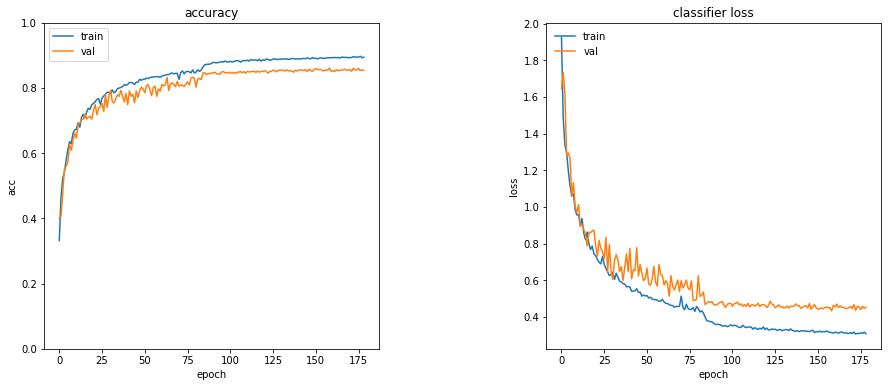

In [52]:
#%tensorboard --logdir logs/
f,ax = plt.subplots(1, 2,figsize=(15,6))
ax[1].plot(history.history['classifier_loss'],label='train')
ax[1].plot(history.history['val_classifier_loss'],label='val')
ax[1].set_title('classifier loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc='upper left', frameon=False)

ax[0].plot(history.history['classifier_acc'])
ax[0].plot(history.history['val_classifier_acc'])
ax[0].set_ylim([0,1])
ax[0].set_title('accuracy')
ax[0].set_ylabel('acc')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

f.subplots_adjust(hspace=0.5)
f.subplots_adjust(wspace=0.5)

plt.show()

aec_model = load_model('aug_cmodel-159-0.892214-0.860400.h5')
# YpredsHot = aec_model.predict(Xtest)
# Ypreds = np.argmax(YpredsHot,axis=1)
# evaluate_classification(Ytest,Ypreds)



### Results: 
#### Autodencoder : reconstruction after joint training  - the error increased 
#### Classifier : classwise classification score - accuracy reduced compared to independent training on image input

0.014670171690930463


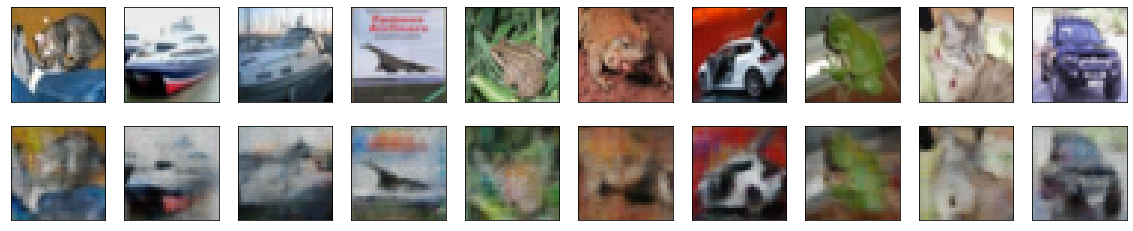

Classification Report:

              precision    recall  f1-score   support

    airplane       0.87      0.91      0.89      1000
  automobile       0.88      0.97      0.92      1000
        bird       0.81      0.80      0.80      1000
         cat       0.76      0.73      0.74      1000
        deer       0.88      0.79      0.83      1000
         dog       0.86      0.76      0.80      1000
        frog       0.81      0.95      0.87      1000
       horse       0.89      0.92      0.90      1000
        ship       0.92      0.91      0.92      1000
       truck       0.94      0.87      0.90      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



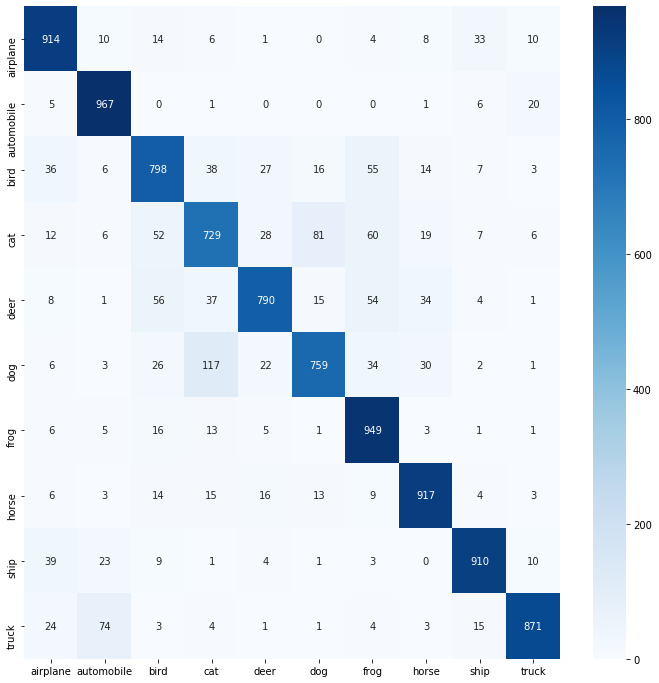

In [53]:
recons_imgs, YpredsHot = aec_model.predict(Xtest)
Ypreds = np.argmax(YpredsHot,axis=1)
visualize_reconstruction(Xtest,recons_imgs)
evaluate_classification(Ytest,Ypreds)

In [54]:
aec_model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
c1 (Conv2D)                     (None, 32, 32, 32)   896         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_89 (BatchNo (None, 32, 32, 32)   128         c1[0][0]                         
__________________________________________________________________________________________________
c2 (Conv2D)                     (None, 32, 32, 32)   9248        batch_normalization_89[0][0]     
___________________________________________________________________________________________

### Feature maps visualization from output layer of encoder and after the first layer of classifier model in end-to-end training

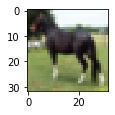

In [55]:
ip_img = Xtest[4100,...]
plt.figure(figsize=(1.5,1.5))
plt.imshow(ip_img)

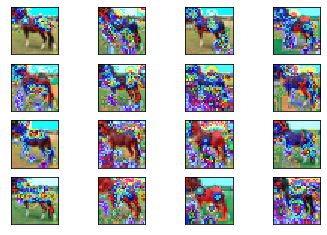

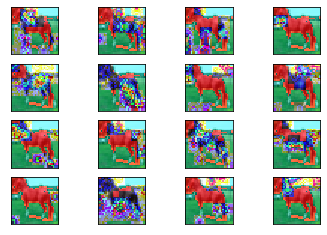

In [56]:
import cv2
ixs = [10,15] #layer indices - encoder layer(name = encoder) and after first layer of classification (name = cbn_1)
img1 = ip_img
img = np.expand_dims(ip_img, axis=0)
outputs = [aec_model.layers[i].output for i in ixs]
model = Model(inputs=aec_model.inputs, outputs=outputs)
feature_maps = model.predict(img)
square = 4
for fmap in feature_maps:
    ix = 1
    for _ in range(square):
        for _ in range(square):
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            filter_i= fmap[0, :, :, ix-1]/fmap[0, :, :, ix-1].max()
            #plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            fmap1 = cv2.resize(filter_i,(32,32))
            fmap1 = cv2.applyColorMap(np.uint8(255 * (255 - fmap1)), cv2.COLORMAP_JET)
            #print(fmap1.shape)
#             for each in range(ip_img.shape[2]):
#                 ip_img[:,:,each] = np.multiply(ip_img[:,:,each],fmap1)
            plt.imshow(((fmap1 * 0.4 + ip_img)*255).astype(np.uint8))
            ix += 1
    plt.show()
